# Imports

In [1]:
import numpy as np
import pymysql
import logging
import os

import random
import matplotlib.pyplot as plt
import time

from typing import List

from dotenv import load_dotenv
load_dotenv()

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
# rds settings
USER = os.environ.get('MELI_APP_USER')
PASSWORD = os.environ.get('MELI_APP_PASSWORD')
ENDPOINT = os.environ.get('MELI_APP_ENDPOINT')
DBNAME = os.environ.get('MELI_APP_DBNAME')

# Utils

In [3]:
def check_sequence(matrix, row, col, dr, dc):
    char = matrix[row][col]
    for i in range(1, 4):
        r, c = row + i * dr, col + i * dc
        if not (0 <= r < len(matrix) and 0 <= c < len(matrix)) or matrix[r][c] != char:
            return False
    return True

def search_mutant(matrix: np.array) -> bool:
    n = len(matrix)
    directions = [(0, 1), (1, 0), (1, 1), (1, -1)]  # Horizontal, vertical, diagonal derecha y diagonal izquierda
    for row in range(n):
        for col in range(n):
            for dr, dc in directions:
                if check_sequence(matrix, row, col, dr, dc):
                    return True
    return False

def is_square_matrix(m: np.array) -> bool:
    return m.shape[0] == m.shape[1]

def dna_to_matrix(dna: List[str]) -> np.array:
    return np.array([list(row) for row in dna])

def process_dna(dna: List[str]):
    
    matrix = np.array(dna_to_matrix(dna))
    assert is_square_matrix(matrix), 'dna no cumple con formato: Matriz cuadrada NxN'
 
    return search_mutant(matrix)

def add_new_dna_result(con: pymysql.connect, is_mutant: bool):
    table_to_insert = 'mutants' if is_mutant else 'humans'
    cur = con.cursor()
    cur.execute(f"""INSERT INTO {table_to_insert} () VALUES ();""")
    con.commit()
    row_count = cur.rowcount
    logger.info(f"{row_count} record inserted.")
    cur.close()

    if(row_count == 1):
        return True
    
    return False

def get_ratio(con: pymysql.connect):
    cur = con.cursor()
    cur.execute("""SELECT count_mutant_data, count_human_data, ratio FROM stats ORDER BY created_at DESC LIMIT 1""")
    results = cur.fetchone()
    results = {
        "count_mutant_data": results[0],
        "count_human_data": results[1],
        "ratio": float(results[2]),
    }

    cur.close()
    return results

def create_db_connection():
    try:
        connection = pymysql.connect(
            host=ENDPOINT,
            database=DBNAME,
            user=USER,
            password=PASSWORD
        )
        return connection
    except pymysql.MySQLError as e:
        logger.error("ERROR: Unexpected error: Could not connect to MySQL instance.")
        logger.error(e)
        return None

# DB Connection

In [4]:
# --------------------------- configure connection --------------------------- #
connection = create_db_connection()

# Queries

In [5]:
# --------------------------------- get ratio -------------------------------- #
results = get_ratio(connection)
print(results)

{'count_mutant_data': 36, 'count_human_data': 4, 'ratio': 9.0}


In [6]:
# ------------------------------- check dna ------------------------------- #
dna = ["ATGCGA", "CAGTGC", "TTATGT", "AGAAGG", "CCCCTA", "TCACTG"]
is_mutant = process_dna(dna)
result = add_new_dna_result(connection, is_mutant)

print(f'Is mutant: {is_mutant}')
print(f'Updated: {result}')

Is mutant: True
Updated: True


# Performance Test

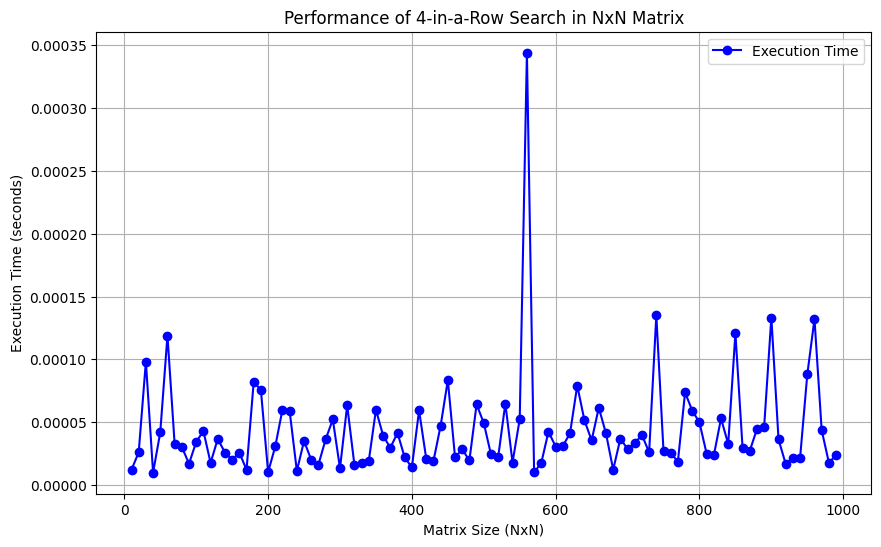

In [7]:
def generate_random_matrix(n):
    characters = ['A', 'T', 'G', 'C']
    return [[random.choice(characters) for _ in range(n)] for _ in range(n)]

matrix_sizes = list(range(10, 1000, 10))
execution_times = []

for size in matrix_sizes:
    matrix = generate_random_matrix(size)
    start_time = time.time()
    search_mutant(matrix)
    end_time = time.time()
    execution_times.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, execution_times, marker='o', color='b', label='Execution Time')
plt.xlabel('Matrix Size (NxN)')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance of 4-in-a-Row Search in NxN Matrix')
plt.legend()
plt.grid(True)
plt.show()